# Determining Trade Union Status

#### Overview
Build a model to predict whether a person will remain in a hypothetical trade union, the United Data Scientists Union (UDSU). Assume a country with a major trade union for data scientists. Each member pays some dues amount to it each month and gets various benefits such as representation with employers and continuing education.

Each ID represents a data scientists who is a current or former member. The dataset will contain several features such as:
- Whether the person is a member of the management
- Number of months the particular data scientist has been a member of the UDSU
- Financial dues paid (each month, and in total)
- Gender of the person
- Status (still a union member; or no longer a member)

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# I. Data Reading

In [2]:
# Read in data
data = pd.read_csv('Marianne-TRAIN.csv', sep=',')

# Dropping ID
data.drop('ID',axis=1,inplace=True)

# Pushing LeftUnion to the end of the columns
cols=data.columns.tolist()
cols=[cols[i] for i in range(len(cols)) if i!=cols.index("LeftUnion")]
cols.append("LeftUnion")
cols
data=data[cols]


In [3]:
data.head()

,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,FeatureA,Connectivity,FeatureC,FeatureD,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues,LeftUnion
0,Female,0,Yes,No,12,No,Maryville,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),50,617,No
1,Female,0,Yes,Yes,51,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,One year,Yes,Electronic check,90,4555,No
2,Female,0,Yes,Yes,57,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,85,4845,No
3,Male,0,No,No,7,Yes,No,other,Maryville,Maryville,Maryville,Maryville,Maryville,Maryville,One year,No,Mailed check,20,129,No
4,Female,0,Yes,No,71,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Electronic check,90,6311,No


# II. Data cleaning

In this section, we will explore and clean the data. We will start by checking for missing values, then we will look at the types and change accordingly. After that, we will look for outliers. Finally, we will perform Standardization and One-Hot Encoding.

### 1) Looking for missing values:

In [4]:
data.isna().sum()/data.shape[0]

gender              0.0
Management          0.0
USAcitizen          0.0
Married             0.0
MonthsInUnion       0.0
ContinuingEd        0.0
FeatureA            0.0
Connectivity        0.0
FeatureC            0.0
FeatureD            0.0
FeatureE            0.0
FeatureF            0.0
FeatureG            0.0
FeatureB            0.0
DuesFrequency       0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyDues         0.0
TotalDues           0.0
LeftUnion           0.0
dtype: float64

#### => The data does not contain missing entries.

### 2) Feature types:

In [5]:
data.dtypes

gender              object
Management           int64
USAcitizen          object
Married             object
MonthsInUnion        int64
ContinuingEd        object
FeatureA            object
Connectivity        object
FeatureC            object
FeatureD            object
FeatureE            object
FeatureF            object
FeatureG            object
FeatureB            object
DuesFrequency       object
PaperlessBilling    object
PaymentMethod       object
MonthlyDues          int64
TotalDues           object
LeftUnion           object
dtype: object

We need to change TotalDues to a float type, then we will replace the resulting NaN values with the median value.

In [6]:
data['TotalDues'] = data['TotalDues'].replace('#VALUE!',np.nan).astype('float')
fillna_value = np.nanmedian(data['TotalDues'])
data['TotalDues'] = data['TotalDues'].fillna(fillna_value)

### 3) Looking for outliers:

Now we will look at a brief description of the continuous variables ("MonthsInUnion","MonthlyDues").

In [7]:
data.drop("Management",axis=1).describe()

,MonthsInUnion,MonthlyDues,TotalDues
count,999.000000,999.000000,999.000000
mean,34.502503,82.599600,2290.348348
std,38.840996,492.294729,2272.771101
min,0.000000,19.000000,19.000000
25%,8.000000,39.000000,417.500000
50%,29.000000,71.000000,1470.000000
75%,56.000000,90.500000,3662.000000
max,602.000000,15453.000000,8478.000000


We notice that the 3rd quartiles of MonthlyDues and MonthsInUnion are way smaller than the maximum values. This might suggest the existence of outliers. Let's do a boxplot to check.

<AxesSubplot:>

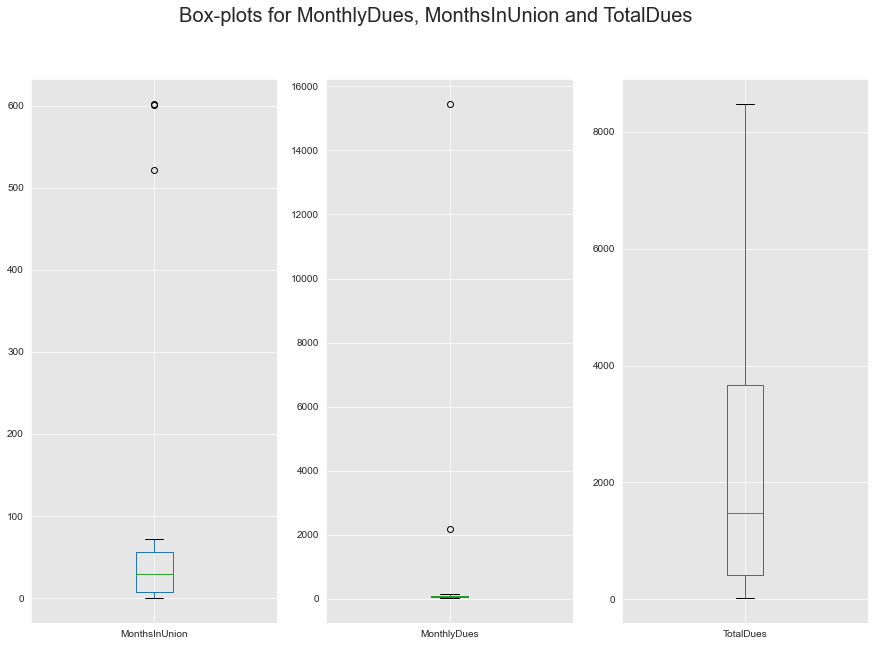

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,10))

fig.suptitle("Box-plots for MonthlyDues, MonthsInUnion and TotalDues", fontsize=20)

data.MonthsInUnion.plot.box(grid=True,ax=axes[0])

data.MonthlyDues.plot.box(grid=True,ax=axes[1])

data.TotalDues.plot.box(grid=True,ax=axes[2])

There are indeed outliers that will impair our models. therefore we should remove them.

In [9]:
data = data[data["MonthlyDues"] < 2000]

data = data[data["MonthsInUnion"] < 500]


### 4) Conversion to numeric and standardization:
For this purpose, we will use the function LabelEncoder to perform encoding for binary variables, get_dummies for categorical variables, and StandardScaler to standardize the float variables.

In [10]:
binary_variables=[]
for col in data.columns:
    if data[col].nunique()==2:
        binary_variables.append(col)
continuous_variables=['MonthsInUnion','MonthlyDues','TotalDues']

In [11]:
standard_scalers = []
for col in continuous_variables:
    scaler = StandardScaler()
    data_col = np.array(data[col]).reshape(-1, 1)
    scaler.fit(data_col)
    data[col] = scaler.transform(data_col)
    standard_scalers.append(scaler)

    
encoders=[]
for col in binary_variables:
    enc=LabelEncoder()
    enc.fit(data[col])
    data[col]=enc.transform(data[col])
    encoders.append(enc)

data= pd.get_dummies(data)


### How our data looks like after cleaning.

In [12]:
data.head()

,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,PaperlessBilling,MonthlyDues,TotalDues,LeftUnion,...,FeatureB_Maryville,FeatureB_No,FeatureB_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-0.834473,0,1,-0.501206,-0.737056,0,...,0,0,1,1,0,0,1,0,0,0
1,0,0,1,1,0.724505,1,1,0.836238,0.996526,0,...,0,0,1,0,1,0,0,0,1,0
2,0,0,1,1,0.964348,1,1,0.669058,1.124190,0,...,0,0,1,0,0,1,0,0,1,0
3,1,0,0,0,-1.034342,1,0,-1.504289,-0.951883,0,...,1,0,0,0,1,0,0,0,0,1
4,0,0,1,0,1.523981,1,0,0.836238,1.769550,0,...,0,0,1,0,0,1,0,0,1,0


# III. PCA and Correlation

In this section, we will plot scatter plots for continuous variables. Then we will compute the correlation between features and the target. Then we will apply PCA and visualize the scree plot.

### 1) Scatter plots of continuous variables

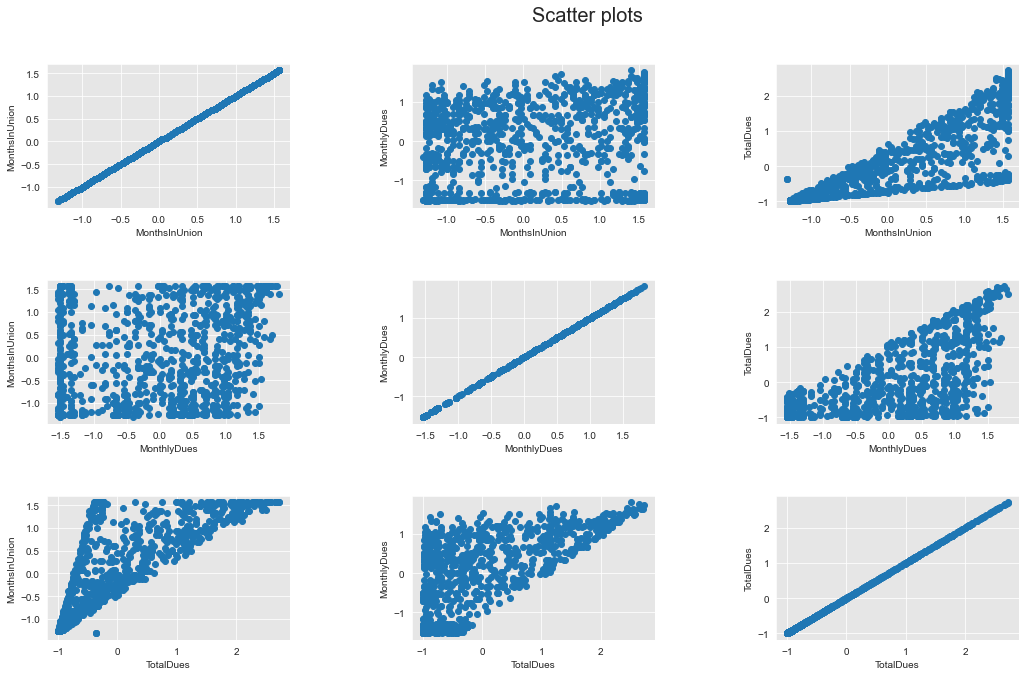

In [13]:
fig, ax = plt.subplots(figsize=(20,10),nrows=3,ncols=3)
title='Scatter plots'
fig.suptitle(title, fontsize=20)
columns='MonthsInUnion','MonthlyDues','TotalDues' 
for j in range(len(columns)):
    for k in range(len(columns)):
        ax[j,k].scatter(x=data[columns[j]],y=data[columns[k]])
        ax[j,k].set_xlabel(columns[j])
        ax[j,k].set_ylabel(columns[k])

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)
plt.show()


There is no obvious pattern between the three continuous variables.

### 2) Correlation between predictors and Y

In [14]:
from scipy.stats import pearsonr
def corr_and_pval(data):
    coeffmat = np.zeros((data.shape[1], data.shape[1]))
    pvalmat = np.zeros((data.shape[1], data.shape[1]))

    for i in range(data.shape[1]):    
        for j in range(data.shape[1]):
            corrtest = pearsonr(data[data.columns[i]], data[data.columns[j]])

            coeffmat[i,j] = corrtest[0]
            pvalmat[i,j] = corrtest[1]
    return coeffmat, pvalmat

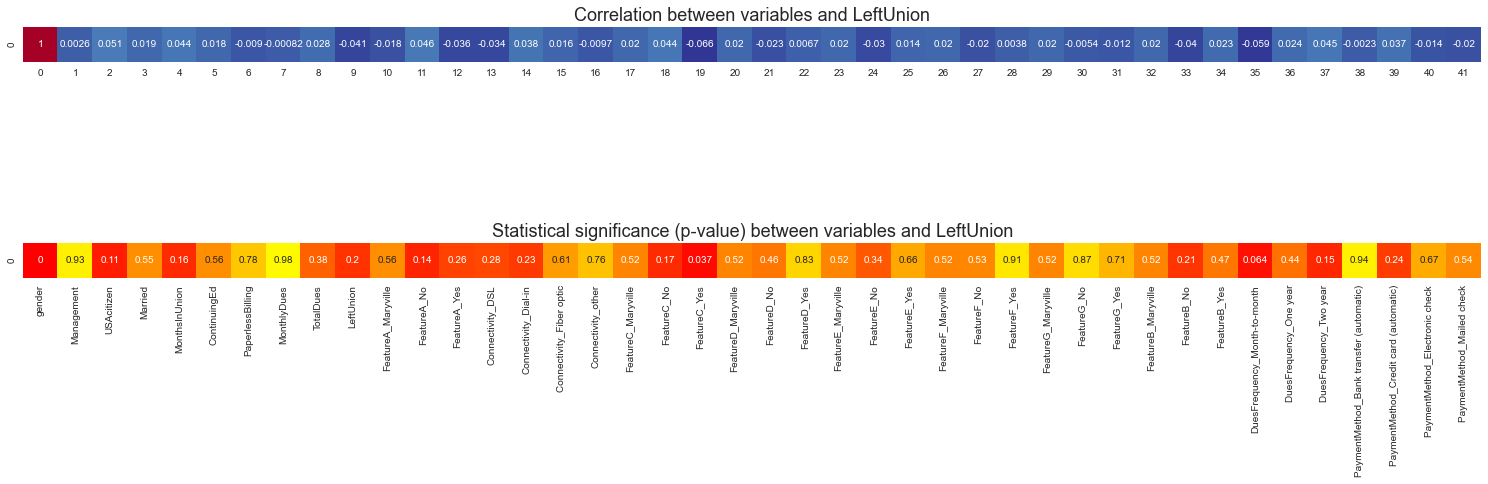

In [15]:
fig, (ax1,ax2) =plt.subplots(2,1,figsize=(30,5))

title="Correlation between variables and LeftUnion"
title2="Statistical significance (p-value) between variables and LeftUnion"
    
sns.heatmap(np.transpose(corr_and_pval(data)[0][0].reshape(corr_and_pval(data)[0][:,0].shape[0],1)),vmax=1,square=True,annot=True,cmap='RdYlBu_r',cbar=False,ax=ax1)
ax1.set_title(title,fontdict={'fontsize': 18})
    
sns.heatmap(np.transpose(corr_and_pval(data)[1][0].reshape(corr_and_pval(data)[1][:,0].shape[0],1)),xticklabels=data.columns,vmax=1,square=True,annot=True,cmap="autumn",cbar=False,ax=ax2)
ax2.set_title(title2,fontdict={'fontsize': 18})

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=2, wspace=0.5)


From the Pearson correlation matrix, we can see that there not a single variable that is highly correlated with the target. Later on, we will perform Recursive Feature Elimination with the modeling section.

### 3) PCA

In [16]:
from sklearn.decomposition import PCA

num_pc=data.shape[1]-1
pca = PCA(n_components=num_pc) 
pca.fit(data.drop('LeftUnion',axis=1))
eigenvalues = pca.explained_variance_
pca_components = pca.components_

Scree plot

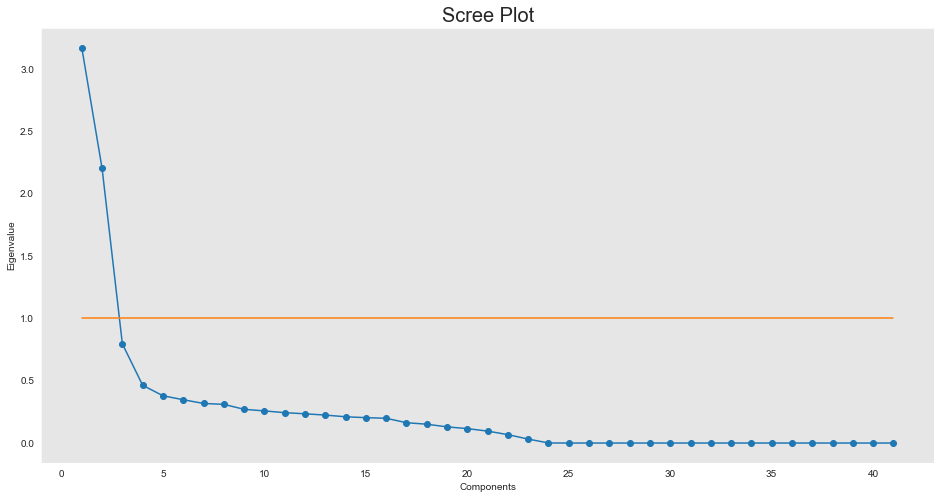

In [17]:
plt.figure(figsize=(16,8))
plt.scatter(range(1,data.shape[1]),eigenvalues)
plt.plot(range(1,data.shape[1]),eigenvalues)
plt.plot(range(1,data.shape[1]),eigenvalues/eigenvalues) #the 1 eigenvalue line
plt.title('Scree Plot',fontsize=20)
plt.xlabel('Components')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# IIII. Feature selection and Modeling

In this section, we will apply Recursive Feature Elimination with Logistic Regression, then we will use the optimal features with Logistic Regression and SVM. And we will do the same with Decision Tree and Random Forest.

In [18]:
X=data.drop('LeftUnion',axis=1)
y=data['LeftUnion']

### 1) Logistic Regression

Feature Selection by Elimination with Logistic Regression

In [19]:
scores_arr = []
for to_select in range(10,41):
    clf = LogisticRegression(random_state=0,max_iter=1000)
    selector = RFE(clf, n_features_to_select = to_select)
    selector.fit(X, y)
    ranking = selector.ranking_
    best_features = np.where(ranking==1)
    
    clf = LogisticRegression(random_state=0,max_iter=1000)
    scores = cross_val_score(clf, X.iloc[:,best_features[0]], y, cv=10)
    scores_arr.append(np.mean(scores))


clf = LogisticRegression(random_state=0,max_iter=1000)
selector = RFE(clf, n_features_to_select = np.argmax(scores_arr)+10)
selector.fit(X,y)
ranking = selector.ranking_
best_features = np.where(ranking==1)[0]
print('Considering {} features only.'.format(len(best_features)))
print(X.columns[best_features])

clf = LogisticRegression(random_state=0,max_iter=1000)
np.mean(cross_val_score(clf, X.iloc[:,best_features], y, cv=10))

Considering 21 features only.
Index(['gender', 'Management', 'Married', 'MonthsInUnion', 'ContinuingEd',
       'PaperlessBilling', 'TotalDues', 'FeatureA_Maryville', 'FeatureA_No',
       'Connectivity_DSL', 'Connectivity_Fiber optic', 'FeatureC_No',
       'FeatureD_No', 'FeatureF_No', 'FeatureF_Yes', 'FeatureG_Yes',
       'FeatureB_Yes', 'DuesFrequency_Month-to-month',
       'DuesFrequency_One year', 'DuesFrequency_Two year',
       'PaymentMethod_Bank transfer (automatic)'],
      dtype='object')


0.7942222222222222

Train test split for the new data (with extracted features)

In [20]:
# train test split & holdout set
X_train, X_hold, y_train, y_hold = train_test_split(X.iloc[:,best_features], y, test_size=0.2, 
                                                    random_state=1)

# train test split & test set
X_valid, X_test, y_valid, y_test = train_test_split(X_hold, y_hold, test_size=0.5, 
                                                    random_state=1)
print(f'Training Features Shape:   {X_train.shape}')
print(f'Validation Features Shape: {X_valid.shape}')
print(f'Test Features Shape:       {X_test.shape}')

Training Features Shape:   (796, 21)
Validation Features Shape: (100, 21)
Test Features Shape:       (100, 21)


Best Logistic Regression Model

In [21]:
clf = LogisticRegression(random_state=0,max_iter=1000)
lr_mod = clf.fit(X.iloc[:,best_features], y)

print(f'Training Accuracy: {lr_mod.score(X_train,y_train).round(4)}')
print(f'Testing Accuracy:  {lr_mod.score(X_test,y_test).round(4)}')

Training Accuracy: 0.7977
Testing Accuracy:  0.83


### 2) SVM

Iterating on a few number of degrees to find the best degree for polynomial SVM Classifier.

In [22]:
svc_train_acc = []
svc_valid_acc = []
c_range=[2,3,4,5]
for c in c_range:
    temp_svc = SVC(kernel='poly', degree=c, random_state=1)
    temp_svc.fit(X_train, y_train)
    svc_train_acc.append(temp_svc.score(X_train, y_train))
    svc_valid_acc.append(temp_svc.score(X_valid, y_valid))
    
svc_idx = np.argmax(svc_valid_acc)
svc_opt_depth = c_range[svc_idx]
svc_opt_train_acc = svc_train_acc[svc_idx]
svc_opt_valid_acc = svc_valid_acc[svc_idx]

print(f'Optimal value for degree:           {svc_opt_depth}')
print(f'Training Accuracy for Optimal Model:   {svc_opt_train_acc.round(4)}')
print(f'Validation Accuracy for Optimal Model: {svc_opt_valid_acc.round(4)}')

Optimal value for degree:           5
Training Accuracy for Optimal Model:   0.9146
Validation Accuracy for Optimal Model: 0.8


Best SVM model

In [23]:
svc0 = SVC(kernel='poly', degree=c, random_state=1)
svc = svc0.fit(X.iloc[:,best_features], y)

print(f'Training Accuracy: {svc.score(X_train,y_train).round(4)}')
print(f'Testing Accuracy:  {svc.score(X_test,y_test).round(4)}')

Training Accuracy: 0.907
Testing Accuracy:  0.91


### 3) Decision Tree

Feature Selection by Elimination with Decision Tree

In [24]:
scores_arr = []
for to_select in range(10,41):
    clf1 = DecisionTreeClassifier(max_depth=None, random_state=1)
    selector = RFE(clf1, n_features_to_select = to_select)
    selector.fit(X, y)
    ranking = selector.ranking_
    best_features = np.where(ranking==1)
    
    clf1 = DecisionTreeClassifier(max_depth=None, random_state=1)
    scores = cross_val_score(clf1, X.iloc[:,best_features[0]], y, cv=10)
    scores_arr.append(np.mean(scores))


clf1 = DecisionTreeClassifier(max_depth=None, random_state=1)
selector = RFE(clf1, n_features_to_select = np.argmax(scores_arr)+10)
selector.fit(X,y)
ranking = selector.ranking_
best_features = np.where(ranking==1)[0]
print('Considering {} features only.'.format(len(best_features)))
print(X.columns[best_features])

clf1 = DecisionTreeClassifier(max_depth=None, random_state=1)
np.mean(cross_val_score(clf1, X.iloc[:,best_features], y, cv=10))

Considering 11 features only.
Index(['Management', 'MonthsInUnion', 'PaperlessBilling', 'MonthlyDues',
       'TotalDues', 'FeatureA_No', 'Connectivity_Fiber optic', 'FeatureD_No',
       'FeatureF_No', 'DuesFrequency_Month-to-month',
       'PaymentMethod_Electronic check'],
      dtype='object')


0.7469595959595959

Train test split for the new data (with extracted features)

In [25]:
# train test split & holdout set
X_train, X_hold, y_train, y_hold = train_test_split(X.iloc[:,best_features], y, test_size=0.2, 
                                                    random_state=1)

# train test split & test set
X_valid, X_test, y_valid, y_test = train_test_split(X_hold, y_hold, test_size=0.5, 
                                                    random_state=1)
print(f'Training Features Shape:   {X_train.shape}')
print(f'Validation Features Shape: {X_valid.shape}')
print(f'Test Features Shape:       {X_test.shape}')

Training Features Shape:   (796, 11)
Validation Features Shape: (100, 11)
Test Features Shape:       (100, 11)


Determining the optimal max_depth

In [26]:
dt_train_acc = []
dt_valid_acc = []

depth_range = range(10,41)

for d in depth_range:
    temp_tree = DecisionTreeClassifier(max_depth=d, random_state=1)
    temp_tree.fit(X_train, y_train)
    dt_train_acc.append(temp_tree.score(X_train, y_train))
    dt_valid_acc.append(temp_tree.score(X_valid, y_valid))

dt_idx = np.argmax(dt_valid_acc)
dt_opt_depth = depth_range[dt_idx]
dt_opt_train_acc = dt_train_acc[dt_idx]
dt_opt_val_acc = dt_valid_acc[dt_idx]

print(f'Optimal value for max_depth:           {dt_opt_depth}')
print(f'Training Accuracy for Optimal Model:   {dt_opt_train_acc.round(4)}')
print(f'Validation Accuracy for Optimal Model: {dt_opt_val_acc.round(4)}')

Optimal value for max_depth:           10
Training Accuracy for Optimal Model:   0.9598
Validation Accuracy for Optimal Model: 0.78


Training and validation accuracy as a function of max_depth

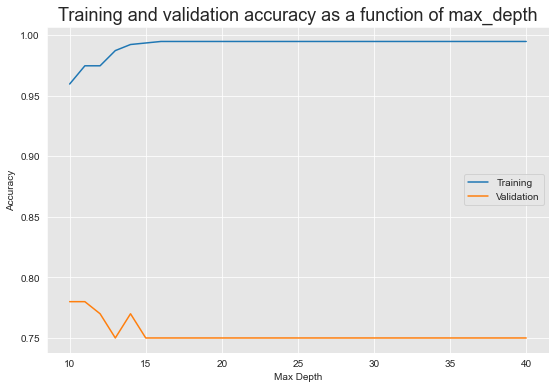

In [27]:
plt.figure(figsize=([9,6]))
plt.title("Training and validation accuracy as a function of max_depth",fontsize=18)
plt.plot(depth_range, dt_train_acc, label='Training')
plt.plot(depth_range, dt_valid_acc, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Best Decision Tree Model

In [28]:
# evaluate decision tree model
dt0 = DecisionTreeClassifier(max_depth=13, random_state=1)
dt = dt0.fit(X_train, y_train)

print(f'Training Accuracy for Final Model:   {dt.score(X_train, y_train).round(4)}')
print(f'Validation Accuracy for Final Model: {dt.score(X_valid, y_valid).round(4)}')
print(f'Testing Accuracy for Final Model:    {dt.score(X_test, y_test).round(4)}')

Training Accuracy for Final Model:   0.9874
Validation Accuracy for Final Model: 0.75
Testing Accuracy for Final Model:    0.69


A small visualization of the Decision Tree

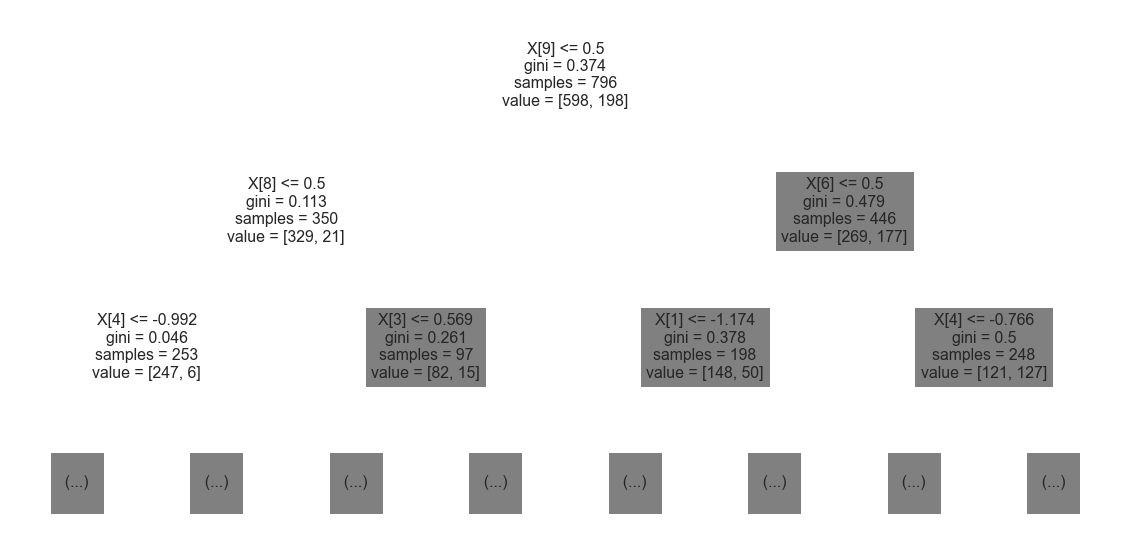

In [29]:
from sklearn import tree

plt.figure(figsize=(20,10))
tree.plot_tree(dt,max_depth=2);

This gives us a small insight on how the Decision Tree works. The first level uses the variable X[9], which is 'DuesFrequency_Month-to-month', and splits the data according to the binarity of that variable. The second level uses 'Connectivity_Fiber optic' and 'FeatureF_No'. Etc...

### 4) Random Forest Model

Determining optimal max_depth

In [30]:
rf_train_acc = []
rf_valid_acc = []

for d in depth_range:
    temp_forest = RandomForestClassifier(n_estimators=1000, max_depth=d, random_state=1)
    temp_forest.fit(X_train, y_train)
    rf_train_acc.append(temp_forest.score(X_train, y_train))
    rf_valid_acc.append(temp_forest.score(X_valid, y_valid))
    
rf_idx = np.argmax(rf_valid_acc)
rf_opt_depth = depth_range[rf_idx]
rf_opt_train_acc = rf_train_acc[rf_idx]
rf_opt_valid_acc = rf_valid_acc[rf_idx]

print(f'Optimal value for max_depth:           {rf_opt_depth}')
print(f'Training Accuracy for Optimal Model:   {rf_opt_train_acc.round(4)}')
print(f'Validation Accuracy for Optimal Model: {rf_opt_valid_acc.round(4)}')

Optimal value for max_depth:           10
Training Accuracy for Optimal Model:   0.9912
Validation Accuracy for Optimal Model: 0.83


Plotting training and validation accuracy as a function of max_depth

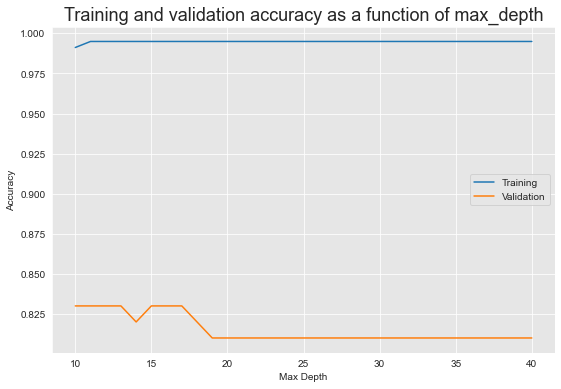

In [31]:
plt.figure(figsize=([9,6]))
plt.title("Training and validation accuracy as a function of max_depth",fontsize=18)
plt.plot(depth_range, rf_train_acc, label='Training')
plt.plot(depth_range, rf_valid_acc, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Best Random Forest model

In [32]:
# evaluate random forest model
rfm0 = RandomForestClassifier(n_estimators=100, max_depth=11, random_state=1)
rfm = rfm0.fit(X_train, y_train)

print(f'Training Accuracy for Final Model:   {rfm0.score(X_train, y_train).round(4)}')
print(f'Validation Accuracy for Final Model: {rfm0.score(X_valid, y_valid).round(4)}')
print(f'Testing Accuracy for Final Model:    {rfm0.score(X_test, y_test).round(4)}')

Training Accuracy for Final Model:   0.9937
Validation Accuracy for Final Model: 0.82
Testing Accuracy for Final Model:    0.8


The best model that we have overall (training convergence and testing accuracy) is Random Forest. This is the classification report for its output.

In [33]:
from sklearn.metrics import classification_report

pred=rfm.predict(X.iloc[:,best_features])
print(classification_report(pred,y))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97       759
           1       0.89      0.93      0.91       237

    accuracy                           0.96       996
   macro avg       0.94      0.95      0.94       996
weighted avg       0.96      0.96      0.96       996



# V. Predict and save

In [34]:
test_data = pd.read_csv("DSCI-508-Competition-Test_Data.csv")
index_test = test_data.iloc[:,0]
X_test = test_data.iloc[:,1:] #remove index column
X_test['TotalDues'] = X_test['TotalDues'].replace('#VALUE!',np.nan).astype('float')
fillna_value = np.nanmedian(X_test['TotalDues'])
X_test['TotalDues'] = X_test['TotalDues'].fillna(fillna_value)

for col in continuous_variables:
    X_test[col] = standard_scalers[continuous_variables.index(col)].transform(np.array(X_test[col]).reshape(-1, 1))

for col in binary_variables:
    data[col]=encoders[binary_variables.index(col)].fit_transform(data[col])
    
X_test = pd.get_dummies(X_test)
X_test = X_test.reindex(columns = X.columns, 
                        fill_value=0)



In [35]:
y_preds = rfm0.predict(X_test.iloc[:,best_features])

result = pd.DataFrame([])
result[0] = index_test
result[1] = y_preds
result.to_csv('Final_Project_Predictions.csv',index=False,header=None)